# Pneumonia Detection in Chest X-Rays: Exploratory Data Analysis (EDA)

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Notebook structure:

* [Import](#Import)
* [Load data](#Load)
* [EDA](#EDA)
* [Summary of Findings](#Summary)

Also, **describe your findings and how will you set up the model training based on the findings.**

---

# Import

In [1]:
import os
from glob import glob
from itertools import chain
from skimage import io

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
def get_gender_info(df):
    ax = sns.countplot(x="Patient Gender", data=df)
    plt.show()
    
    count_m = len(df[df['Patient Gender'] == 'M'])
    count_f = len(df[df['Patient Gender'] == 'F'])
    count_total = df.shape[0]

    print('''Gender\tCount\tPercent
    Male\t{}\t{:.2f}%
    Female\t{}\t{:.2f}%
    '''.format(count_m,
               count_m*100/count_total,
               count_f,
               count_f*100/count_total))

In [3]:
def get_viewpos_info(df):
    ax = sns.countplot(x="View Position", data=df)
    plt.show()
    
    count_ap = len(df[df['View Position'] == 'AP'])
    count_pa = len(df[df['View Position'] == 'PA'])
    count_total = df.shape[0]

    print('''View Position\tCount\tPercent
    AP\t\t{}\t{:.2f}%
    PA\t\t{}\t{:.2f}%'''.format(count_ap,
               count_ap*100/count_total,
               count_pa,
               count_pa*100/count_total))

In [4]:
def get_dist_plot(df_col):
    ax = sns.distplot(df_col, rug=True)
    try:
        ax.set_xlim(0,df_col.max())
    except:
        None
    plt.show()

In [5]:
def get_unique_labels(col):
    labels = set()
    for l in col.unique():
        labels.update(l.split('|'))
    print('Total unique labels: {}'.format(len(labels)))
    return labels

In [6]:
def split_labels_cols(labels, df):
    for l in labels:
        df[l] = df['Finding Labels'].map(lambda x: 1.0 if l in x else 0)

In [7]:
def get_df_disease_per_patient(df):
    df_disease_per_patient = df.groupby(['Patient ID'])[list(labels)].sum()
    for col in labels:
        df_disease_per_patient[col] = df_disease_per_patient[col].apply(lambda x: 1 if x != 0 else 0)
    df_disease_per_patient['sum_diseases'] = df_disease_per_patient.sum(axis=1)
    return df_disease_per_patient   

In [8]:
def show_image_mask(img_data, bg_th):
    # modified from @glungu
    mask = img_data > bg_th
    f = plt.figure(figsize = (16, 5))

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    get_dist_plot(img_data[mask])

    plt.show()

In [9]:
def normalize_img(pixel_array):
    mean_intensity = np.mean(pixel_array)
    std_intensity = np.std(pixel_array)
    return (pixel_array.copy() - mean_intensity)/std_intensity

In [10]:
def get_intensities(label, bg_th):
    # modified from @glungu
    paths = list(df_sample[df_sample[label]==1]['img_path'].values)
    pneu_int = []
    for path in paths:
        img = normalize_img(io.imread(path))
        mask = img > bg_th
        pneu_int.extend(img[mask].flatten().tolist())
        return pneu_int

---

# Load

In [11]:
!ls -l /data

total 19348
-rw-r--r-- 1 root root 8963138 Sep 25  2019 ARXIV_V5_CHESTXRAY.pdf
-rw-r--r-- 1 root root   92416 Sep 25  2019 BBox_List_2017.csv
-rw-r--r-- 1 root root 7861152 Sep 25  2019 Data_Entry_2017.csv
-rw-r--r-- 1 root root   72223 Sep 25  2019 FAQ_CHESTXRAY.pdf
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_001
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_002
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_003
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_004
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_005
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_006
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_007
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_008
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_009
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_010
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_011
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_012
-rw-r--r-- 1 root root    3919 Sep 25  2019 LOG_CHESTXRAY.pdf
-rw-r--r--

## Load NIH data

In [12]:
df_all_xray = pd.read_csv('/data/Data_Entry_2017.csv')
df_all_xray.shape

(112120, 12)

In [13]:
df_all_xray.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
32699,00008547_001.png,Effusion|Nodule,1,8547,26,F,PA,2048,2500,0.168,0.168,NaN
90547,00022543_001.png,No Finding,1,22543,45,M,AP,3056,2544,0.139,0.139,NaN
109775,00029863_021.png,Pneumothorax,21,29863,58,M,AP,3056,2544,0.139,0.139,NaN


In [14]:
df_all_xray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


## Load sample labels for pixel level assessments

In [15]:
df_sample = pd.read_csv('sample_labels.csv')
df_sample.shape

(5606, 11)

In [16]:
df_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3095,00015236_000.png,Effusion,0,15236,058Y,F,PA,2794,2476,0.143,0.143
2411,00012132_003.png,No Finding,3,12132,051Y,F,PA,2992,2991,0.143,0.143
22,00000116_040.png,Cardiomegaly|Consolidation,40,116,075Y,F,AP,2500,2048,0.168,0.168


In [17]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


---

# EDA

* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

In [18]:
df_all_xray.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Image Index,112120,112120,00005504_005.png,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Finding Labels,112120,836,No Finding,60361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Follow-up #,112120,NaN,NaN,NaN,8.57375,15.4063,0,0,3,10,183
Patient ID,112120,NaN,NaN,NaN,14346.4,8403.88,1,7310.75,13993,20673,30805
Patient Age,112120,NaN,NaN,NaN,46.9015,16.8399,1,35,49,59,414
Patient Gender,112120,2,M,63340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
View Position,112120,2,PA,67310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginalImage[Width,112120,NaN,NaN,NaN,2646.08,341.246,1143,2500,2518,2992,3827
Height],112120,NaN,NaN,NaN,2486.44,401.268,966,2048,2544,2991,4715
OriginalImagePixelSpacing[x,112120,NaN,NaN,NaN,0.155649,0.0161738,0.115,0.143,0.143,0.168,0.1988


## Patient Gender

In [19]:
df_all_xray['Patient Gender'].describe()

count     112120
unique         2
top            M
freq       63340
Name: Patient Gender, dtype: object

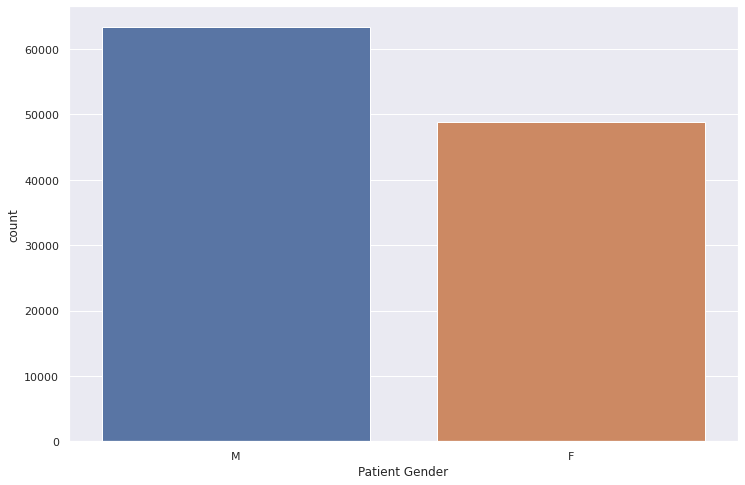

Gender	Count	Percent
    Male	63340	56.49%
    Female	48780	43.51%
    


In [20]:
get_gender_info(df_all_xray)

## Patient Age

In [21]:
df_all_xray['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

A maximum age of 414 seems a bit odd... we can check it out in a distribution plot:

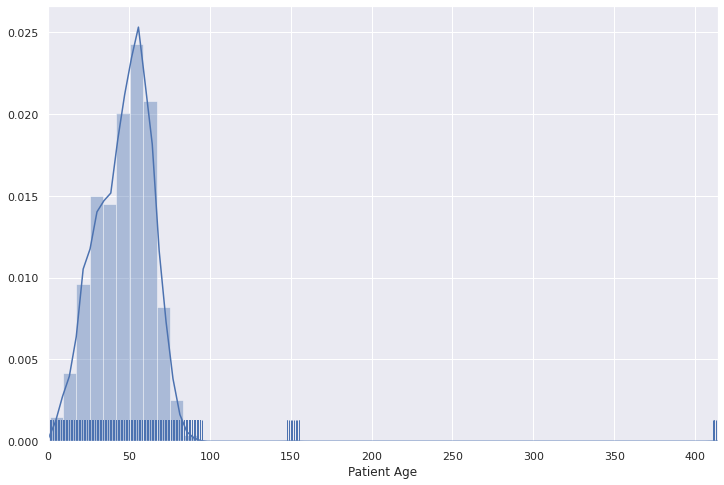

In [22]:
get_dist_plot(df_all_xray['Patient Age'])

We can see that there are quite some **outliers** (i.e., where age > 100).

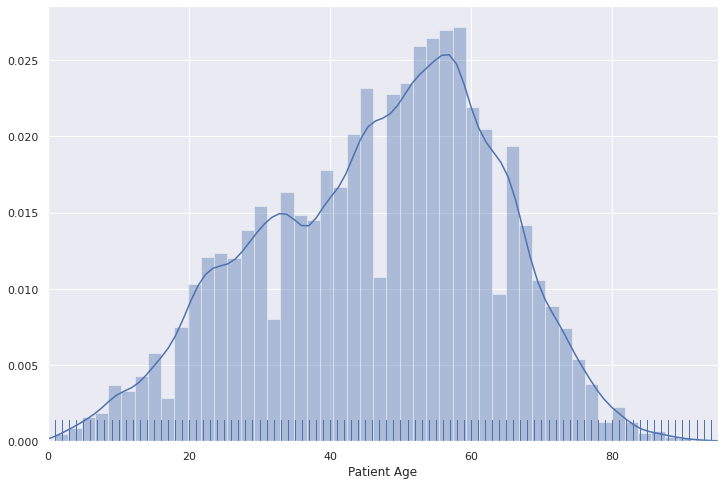

In [23]:
get_dist_plot(df_all_xray[df_all_xray['Patient Age'] <= 100]['Patient Age'])

Omitting the outliers, we can spot a fairly normal distribution of age, with a slight right skew.

Let's check out the outliers:

In [24]:
df_age_over_100 = df_all_xray[df_all_xray['Patient Age'] > 100].sort_values('Patient Age')
df_age_over_100

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
95794,00025206_000.png,Infiltration|Mass,0,25206,153,M,PA,2992,2991,0.143,0.143,NaN
98495,00026028_001.png,Atelectasis,1,26028,154,M,PA,2992,2991,0.143,0.143,NaN
101194,00026871_000.png,No Finding,0,26871,155,F,PA,2992,2991,0.143,0.143,NaN
104590,00027989_000.png,No Finding,0,27989,155,M,PA,2992,2991,0.143,0.143,NaN


In [25]:
df_age_over_100['Patient Age'].unique()

array([148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, 414])

The patient ages above 100 don't make much sense: 148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, 414.

In [26]:
df_age_under_10 = df_all_xray[df_all_xray['Patient Age'] < 10].sort_values('Patient Age')
df_age_under_10

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
25266,00006649_000.png,Effusion|Infiltration,0,6649,1,M,AP,2048,2500,0.115,0.115,NaN
66903,00016529_000.png,No Finding,0,16529,1,F,AP,2048,2500,0.168,0.168,NaN
53114,00013401_000.png,Pleural_Thickening,0,13401,1,M,AP,2500,2048,0.115,0.115,NaN
75175,00018445_002.png,No Finding,2,18445,1,F,AP,2048,2500,0.168,0.168,NaN
39077,00010230_000.png,No Finding,0,10230,1,M,AP,2048,2500,0.115,0.115,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
44150,00011379_019.png,Atelectasis|Effusion,19,11379,9,M,AP,2500,2048,0.168,0.168,NaN
44151,00011379_020.png,No Finding,20,11379,9,M,AP,2500,2048,0.168,0.168,NaN
44152,00011379_021.png,No Finding,21,11379,9,M,AP,2048,2500,0.168,0.168,NaN
91382,00022815_003.png,Atelectasis,3,22815,9,M,AP,2544,3056,0.139,0.139,NaN


Pneumonia [can occur in newborn infants](https://pediatrics.aappublications.org/content/17/2/183), so the data at glance seems fine for younger ages.

## Follow-up

In [27]:
df_all_xray['Follow-up #'].describe()

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

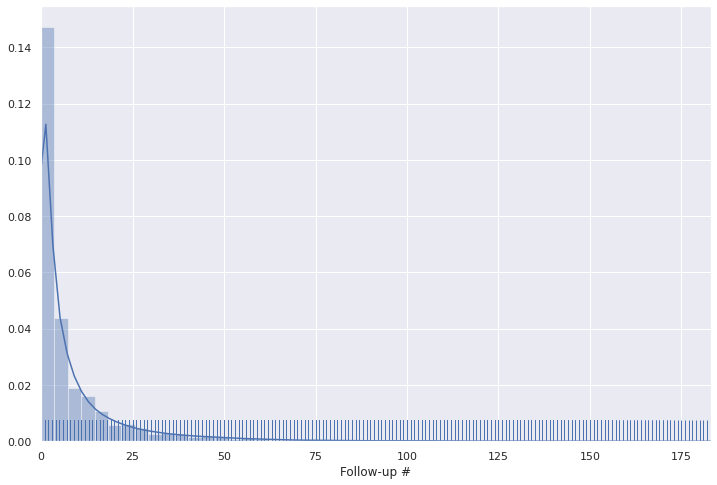

In [28]:
get_dist_plot(df_all_xray['Follow-up #'])

In [29]:
pd.DataFrame(df_all_xray['Follow-up #'].value_counts()).sort_index()

,Follow-up #
0,30805
1,13302
2,9189
3,7089
4,5759
...,...
179,1
180,1
181,1
182,1


The distribution of follow-up # is skewed and seems to be exponential.

## X-Ray views taken

The x-ray views taken (i.e. view position)

In [30]:
df_all_xray['View Position'].describe()

count     112120
unique         2
top           PA
freq       67310
Name: View Position, dtype: object

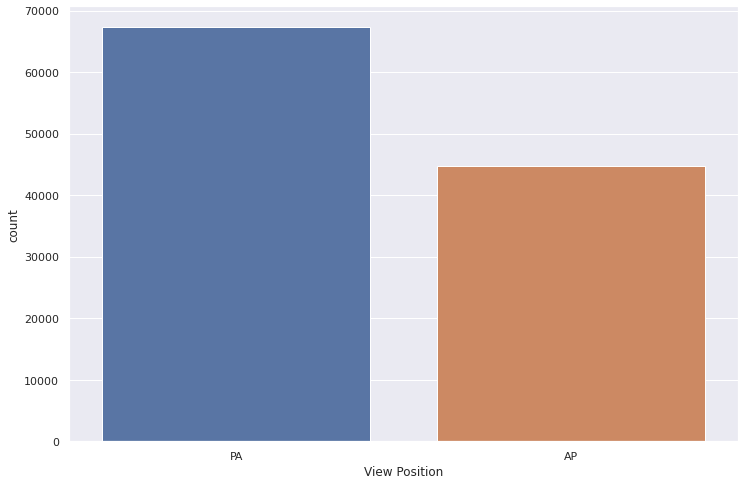

View Position	Count	Percent
    AP		44810	39.97%
    PA		67310	60.03%


In [31]:
get_viewpos_info(df_all_xray)

## Number of records per patient

In [32]:
unique_patients_count = df_all_xray['Patient ID'].nunique()
total_records_count = len(df_all_xray)
avg_records_per_patient = total_records_count/unique_patients_count

print('''Total unique patients:\t\t{}
Total entries:\t\t\t{}
Average records per patient: \t{:.2f}'''.format(unique_patients_count,
                                            total_records_count,
                                            avg_records_per_patient))

Total unique patients:		30805
Total entries:			112120
Average records per patient: 	3.64


On average, there are 3.64 records per patient. Let's look at the distribution of records per patient:

In [33]:
df_all_xray.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [34]:
sr_patients_num_records = df_all_xray.groupby('Patient ID')['Image Index'].count().value_counts().sort_index()

In [35]:
sr_patients_num_records

1      17503
2       4113
3       2100
4       1330
5        938
       ...  
143        1
157        1
158        1
173        1
184        1
Name: Image Index, Length: 103, dtype: int64

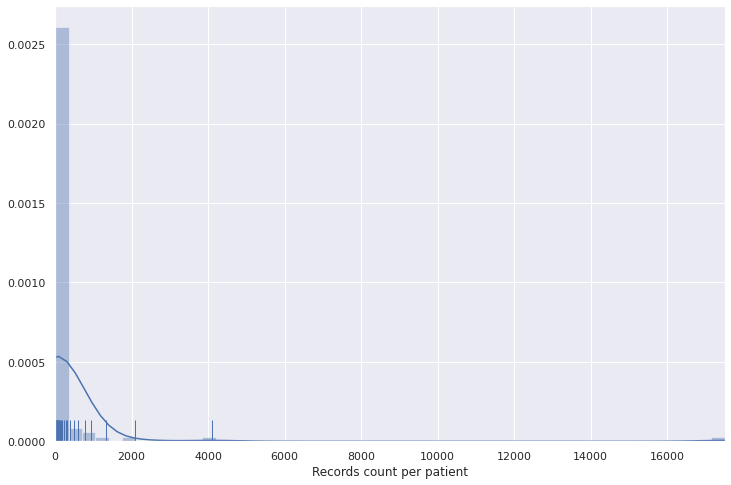

In [36]:
ax = sns.distplot(sr_patients_num_records.rename('Records count per patient'), rug=True)
ax.set_xlim(0,sr_patients_num_records.max())
#ax.set_xticks(list(range(sr_patients_num_records.max())))
plt.show()

In [37]:
sr_patients_num_records.sort_index()[:10]/sr_patients_num_records.sum()

1     0.568187
2     0.133517
3     0.068171
4     0.043175
5     0.030450
6     0.025548
7     0.019737
8     0.016036
9     0.012563
10    0.010388
Name: Image Index, dtype: float64

The number of records per patient distribution seems to be exponential, with more than half (56.82%) of the patients having only one record/image associated with them.

The dataset contains multiple images for some patient. The data splitting should be done on patient level to avoid data leakage.

## Findings labels

In [38]:
labels = get_unique_labels(df_all_xray['Finding Labels'])

Total unique labels: 15


In [39]:
labels

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [40]:
split_labels_cols(labels, df_all_xray)

In [41]:
df_all_xray.sample(3).T

,15875,33974,43046
Image Index,00004196_002.png,00008892_001.png,00011115_001.png
Finding Labels,No Finding,No Finding,No Finding
Follow-up #,2,1,1
Patient ID,4196,8892,11115
Patient Age,55,53,62
Patient Gender,M,M,M
View Position,PA,AP,PA
OriginalImage[Width,2630,2500,2500
Height],2991,2048,2048
OriginalImagePixelSpacing[x,0.143,0.168,0.168


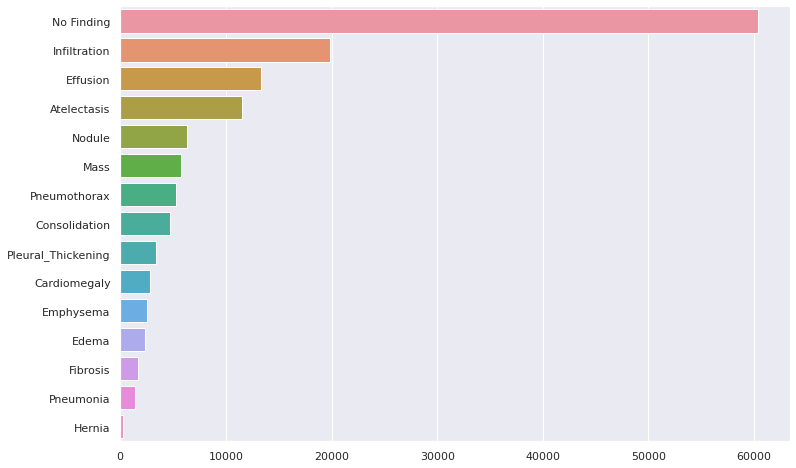

In [42]:
sr_labels_count = df_all_xray[labels].sum().sort_values(ascending=False)
ax = sns.barplot(x=sr_labels_count.values, y=sr_labels_count.index)

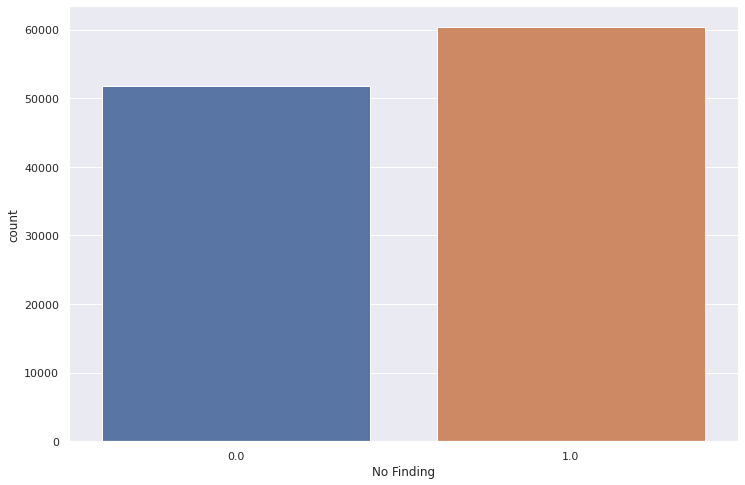

In [43]:
ax = sns.countplot(x="No Finding", data=df_all_xray)
plt.show()

In [44]:
df_all_xray['No Finding'].sum() / len(df_all_xray)

0.5383606849803781

More than half the records have no finding (53.84%). "No Finding" can never appear with any other label by definition, so we know that in 57.5% of this dataset, there is no finding in the image.

## Pneumonia in patients

In [45]:
df_pneumonia = df_all_xray[df_all_xray['Pneumonia'] == 1]
df_pneumonia.shape

(1431, 27)

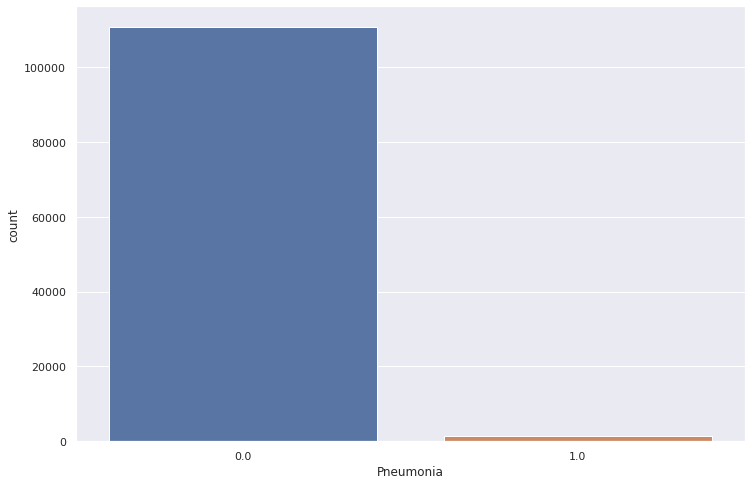

In [46]:
ax = sns.countplot(x="Pneumonia", data=df_all_xray)
plt.show()

In [47]:
count_pneumonia = df_pneumonia.shape[0]
count_nopneumonia = len(df_all_xray) - df_pneumonia.shape[0]

print('''# of pneumonia records: \t{} ({:.2f}%)
# of no-pneumonia records: \t{} ({:.2f}%)'''.format(count_pneumonia,
                                                count_pneumonia/len(df_all_xray)*100,
                                                count_nopneumonia,
                                                count_nopneumonia/len(df_all_xray)*100
                                          ))

# of pneumonia records: 	1431 (1.28%)
# of no-pneumonia records: 	110689 (98.72%)


We are looking at a highly imbalanced dataset, with only very few pneumonia cases (1.28%).

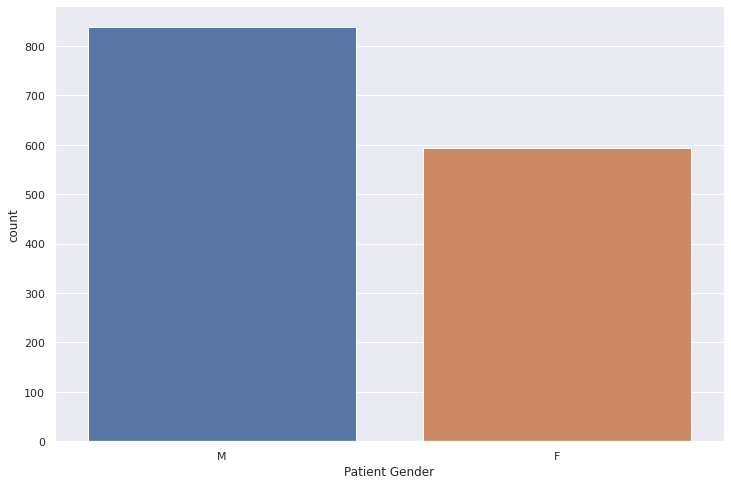

Gender	Count	Percent
    Male	838	58.56%
    Female	593	41.44%
    


In [48]:
# pneumonia by gender

get_gender_info(df_pneumonia)

We see more males (58.56%) within the pneumonia cases than females (41.44%).

In [49]:
# pneumonia by age

df_all_xray.groupby(['Pneumonia'])['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0.0,110689.0,46.926985,16.791759,1.0,35.0,49.0,59.0,414.0
1.0,1431.0,44.927324,20.129866,2.0,31.0,46.0,59.0,412.0


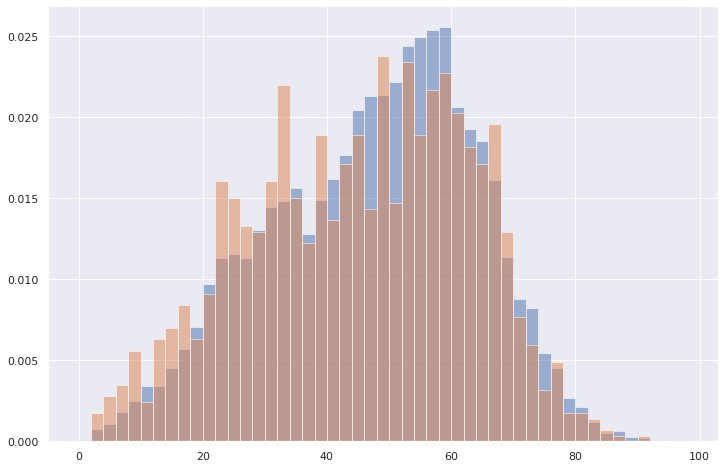

In [50]:
df_all_xray.groupby(['Pneumonia'])['Patient Age'].hist(bins=np.arange(0,100,2), density=True, alpha=0.5)
plt.show()

In [51]:
unique_patients_count = df_pneumonia['Patient ID'].nunique()
total_records_count = len(df_pneumonia)
avg_records_per_patient = total_records_count/unique_patients_count

print('''Total unique patients:\t\t{}
Total entries:\t\t\t{}
Average records per patient: \t{:.2f}'''.format(unique_patients_count,
                                            total_records_count,
                                            avg_records_per_patient))

Total unique patients:		1008
Total entries:			1431
Average records per patient: 	1.42


Average records per pneumonia patient is 1.42.

## Number of diseases per patient

In [52]:
df_disease_per_patient = get_df_disease_per_patient(df_all_xray)

In [53]:
df_disease_per_patient.head(10)

,Infiltration,Nodule,No Finding,Consolidation,Effusion,Hernia,Cardiomegaly,Emphysema,Pleural_Thickening,Mass,Pneumonia,Pneumothorax,Atelectasis,Fibrosis,Edema,sum_diseases
Patient ID,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,3
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2
5,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,3
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,3
9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


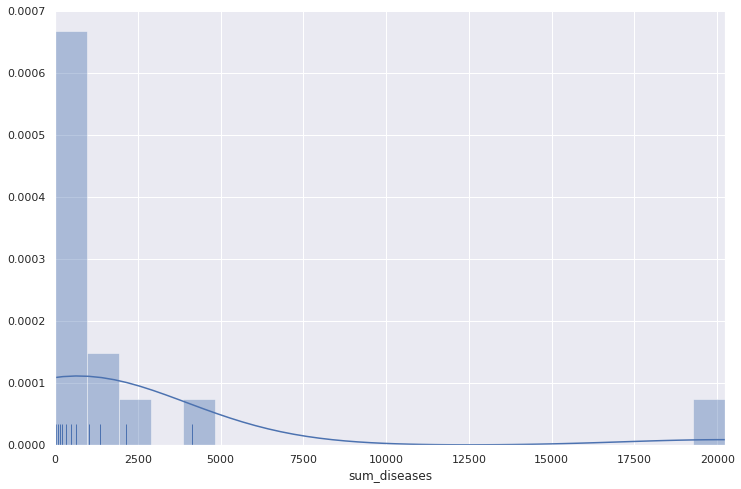

In [54]:
ax = sns.distplot(df_disease_per_patient['sum_diseases'].value_counts().sort_index(), rug=True)
ax.set_xlim(0,df_disease_per_patient['sum_diseases'].value_counts().sort_index().max())
plt.show()

In [55]:
df_disease_per_patient['sum_diseases'].value_counts().sort_index()

1     20224
2      4142
3      2151
4      1361
5      1025
6       631
7       488
8       324
9       200
10      137
11       83
12       28
13        7
14        4
Name: sum_diseases, dtype: int64

In [56]:
(df_disease_per_patient['sum_diseases'].value_counts().sort_index()/len(df_disease_per_patient))

1     0.656517
2     0.134459
3     0.069826
4     0.044181
5     0.033274
6     0.020484
7     0.015842
8     0.010518
9     0.006492
10    0.004447
11    0.002694
12    0.000909
13    0.000227
14    0.000130
Name: sum_diseases, dtype: float64

Most patients have records of only one unique disease (65.65%), some have two (13.45%). Very few patients have three or more unique disease records.

## Distribution of other diseases that are comorbid with pneumonia

* The distribution of other diseases that are comorbid with pneumonia

In [57]:
len(df_disease_per_patient)

30805

In [58]:
len(df_disease_per_patient[df_disease_per_patient['Pneumonia'] == 1])

1008

In [59]:
len(df_disease_per_patient[df_disease_per_patient.drop(['Pneumonia', 'sum_diseases'], axis=1).sum(axis=1) == 0])

27

Out of all 30805 unique patients, 1008 patients have pneumonia. Out of these pneumonia patients, there are 27 unique patients who have only pneumonia and no other disease.

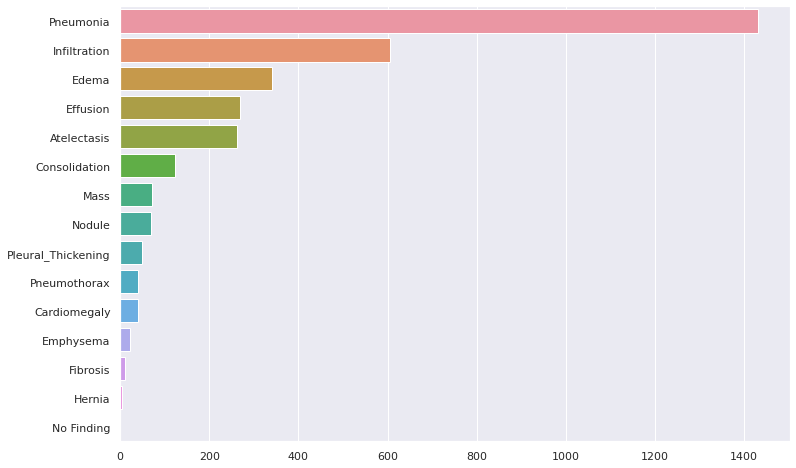

In [60]:
sr_labels_count = df_pneumonia[labels].sum().sort_values(ascending=False)
ax = sns.barplot(x=sr_labels_count.values, y=sr_labels_count.index)

The most common diseases that co-occur with pneumonia are: Infiltration, Edema, Effusion, and Atelectasis.

## Image width, image height and pixel spacing

In [61]:
df_all_xray[['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']].describe().T

,count,mean,std,min,25%,50%,75%,max
OriginalImage[Width,112120.0,2646.078844,341.246429,1143.000,2500.000,2518.000,2992.000,3827.0000
Height],112120.0,2486.438842,401.268227,966.000,2048.000,2544.000,2991.000,4715.0000
OriginalImagePixelSpacing[x,112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
y],112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988


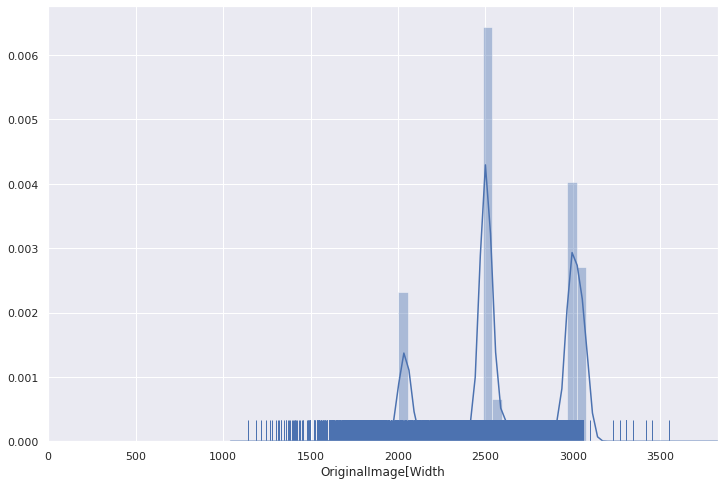

In [62]:
get_dist_plot(df_all_xray['OriginalImage[Width'])

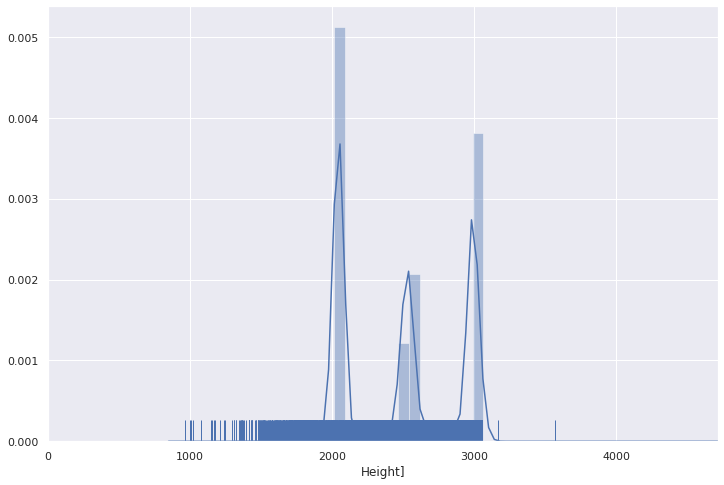

In [63]:
get_dist_plot(df_all_xray['Height]'])

In [64]:
images_w_h = df_all_xray['OriginalImage[Width'].astype(str) +'x'+ df_all_xray['Height]'].astype(str)
images_w_h.value_counts().head(10)

2500x2048    37153
2992x2991    21961
3056x2544    15340
2048x2500     8683
2021x2021     4411
2544x3056     2418
2990x2991      483
2020x2021      331
2021x2020      279
2986x2991      166
dtype: int64

In [65]:
(images_w_h.value_counts()/images_w_h.value_counts().sum()).head(10)

2500x2048    0.331368
2992x2991    0.195870
3056x2544    0.136818
2048x2500    0.077444
2021x2021    0.039342
2544x3056    0.021566
2990x2991    0.004308
2020x2021    0.002952
2021x2020    0.002488
2986x2991    0.001481
dtype: float64

The most common image dimensions are 2500x2048 (33.14%), 2992x2991 (19.59%), and 3056x2544 (13.68%).

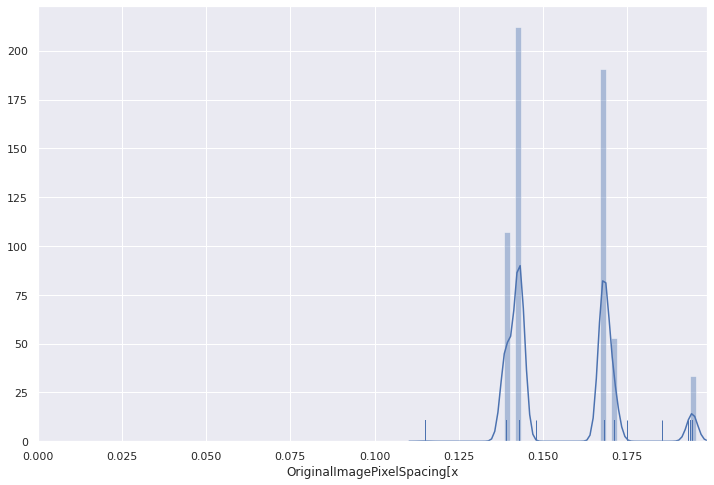

In [66]:
get_dist_plot(df_all_xray['OriginalImagePixelSpacing[x'])

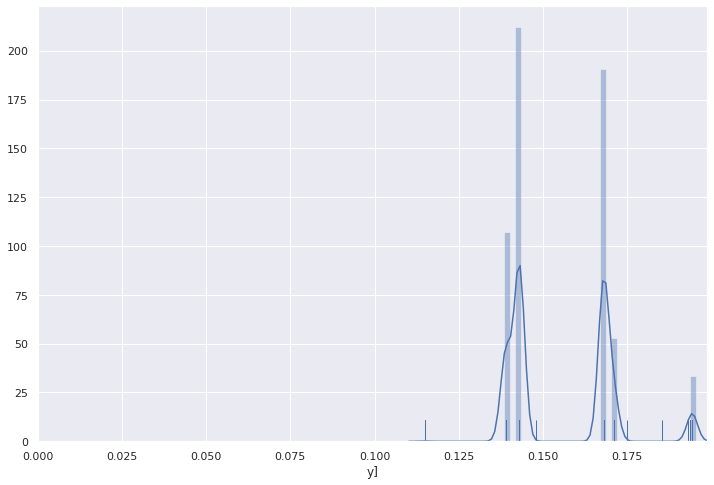

In [67]:
get_dist_plot(df_all_xray['y]'])

## Pixel-level assessments of imaging data

* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [68]:
df_sample.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [69]:
get_unique_labels(df_sample['Finding Labels'])

Total unique labels: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [70]:
split_labels_cols(labels, df_sample)

In [71]:
df_sample.sample(3).T

,4461,2967,1048
Image Index,00022208_005.png,00014625_001.png,00005476_002.png
Finding Labels,Nodule,No Finding,Emphysema
Follow-up #,5,1,2
Patient ID,22208,14625,5476
Patient Age,050Y,027Y,058Y
Patient Gender,M,M,F
View Position,PA,PA,PA
OriginalImageWidth,2992,2992,2500
OriginalImageHeight,2991,2991,2048
OriginalImagePixelSpacing_x,0.143,0.143,0.171


In [72]:
# get entries that have only pneumonia as a disease
df_sample['sum_diseases'] = df_sample.iloc[:,11:].sum(axis=1)

In [73]:
img_paths = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
df_sample['img_path'] = df_sample['Image Index'].map(img_paths.get)

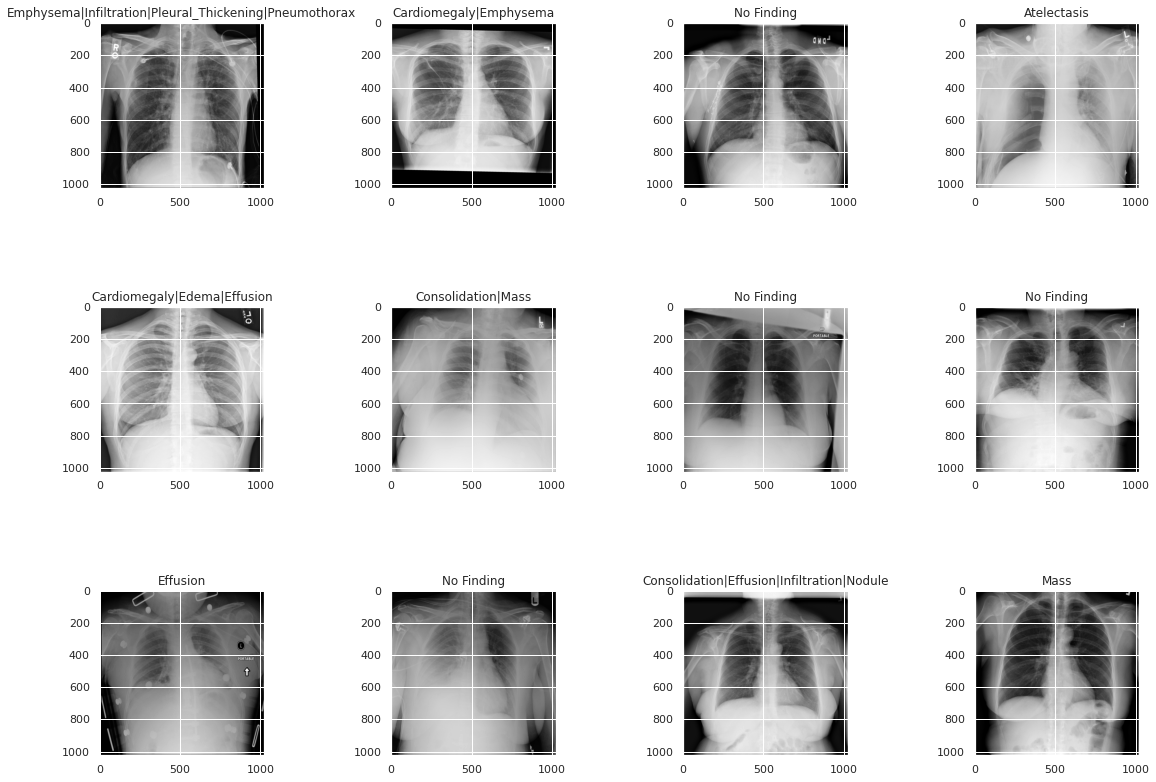

In [74]:
rows=3
cols=4

fig, m_axs = plt.subplots(rows,cols, figsize = (16, 12))
m_axs = m_axs.flatten()
imgs = df_sample.sample(rows*cols).img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df_sample.iloc[ind]['Finding Labels'])
    ind=ind+1
    
plt.tight_layout()

### Sample images of only-pneumonia occurence

In [75]:
df_sample_pneu = df_sample[(df_sample["Pneumonia"] == 1) & (df_sample["sum_diseases"] == 1)]

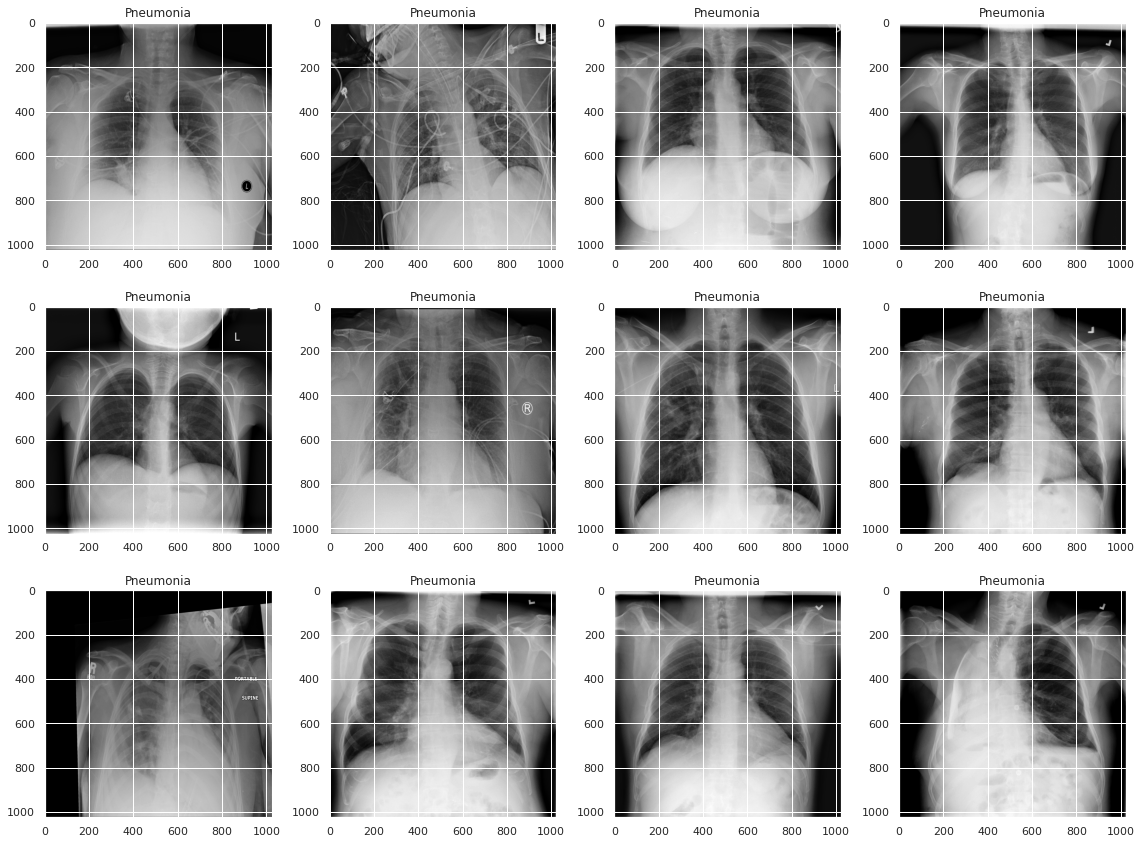

In [76]:
rows=3
cols=4

fig, m_axs = plt.subplots(rows,cols, figsize = (16, 12))
m_axs = m_axs.flatten()
imgs = df_sample_pneu.sample(rows*cols).img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df_sample_pneu.iloc[ind]['Finding Labels'])
    ind=ind+1
    
plt.tight_layout()

In [77]:
df_sample_pneu['img_data'] = df_sample_pneu.apply(lambda x: io.imread(x['img_path']), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Image intensity of pneumonia cases

In [78]:
bg_th = 0.1 # background threshold

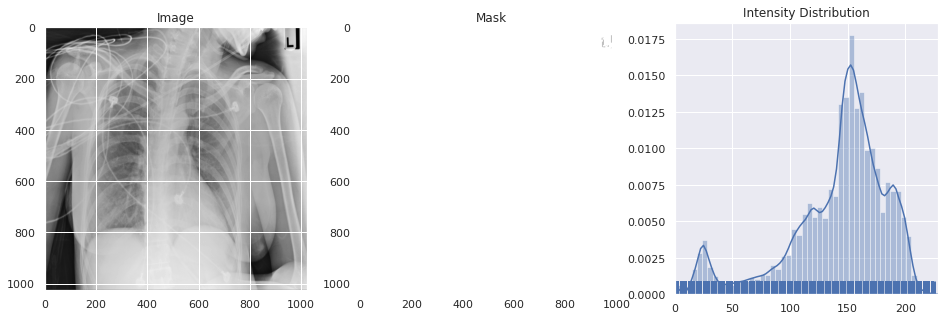

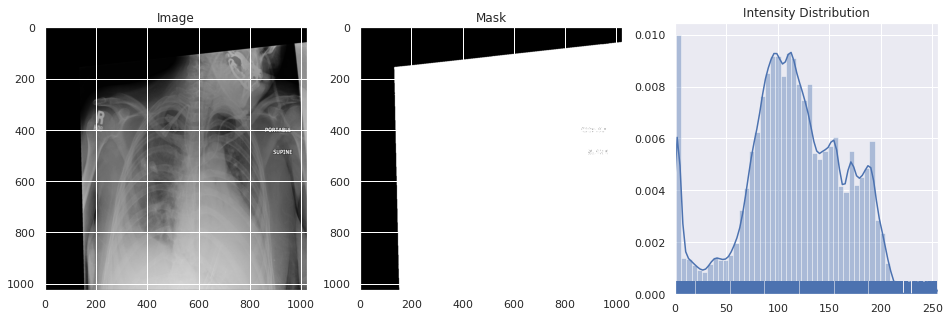

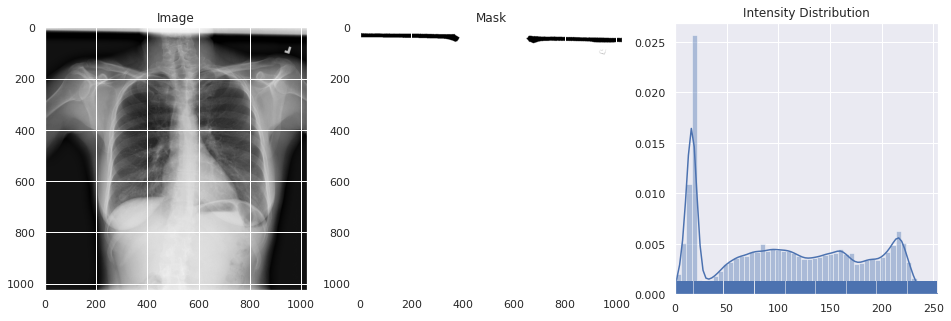

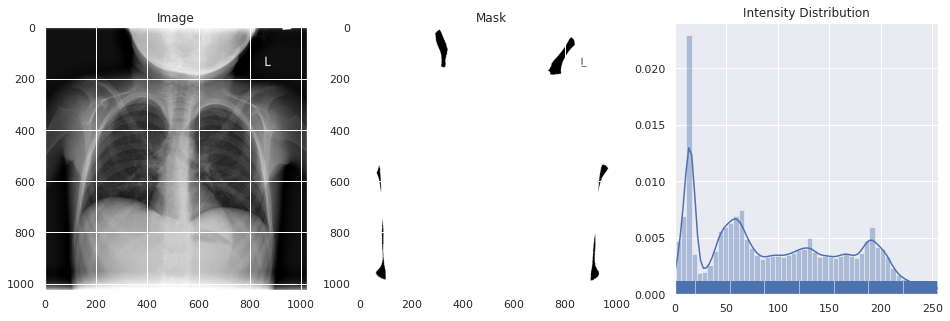

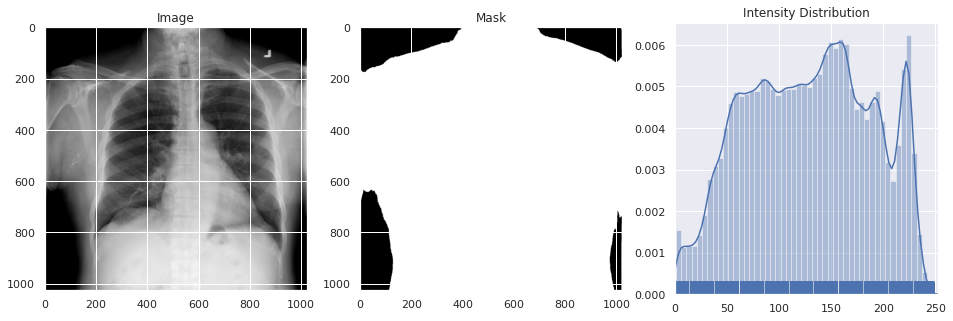

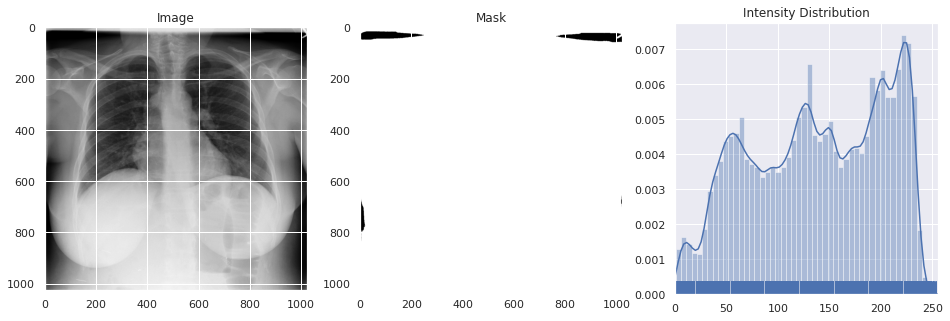

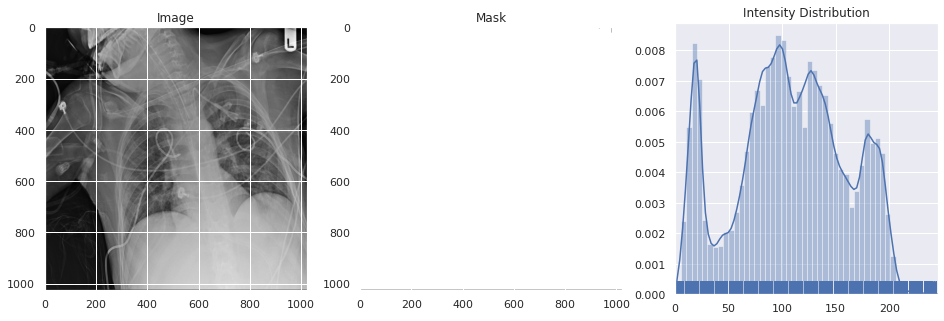

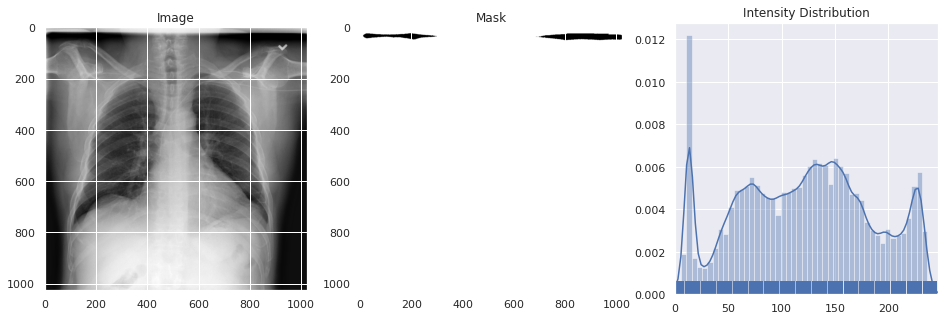

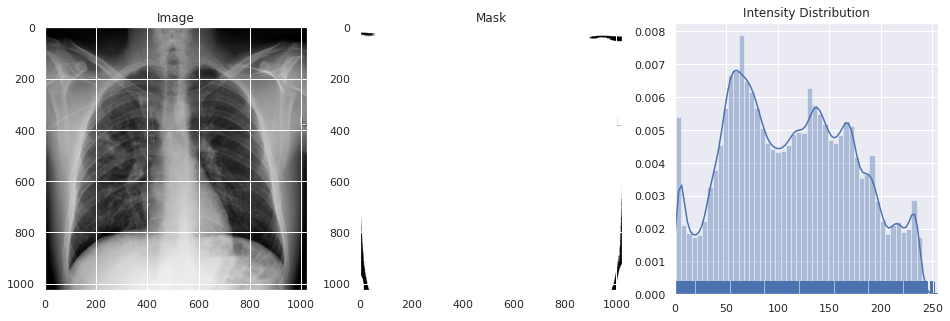

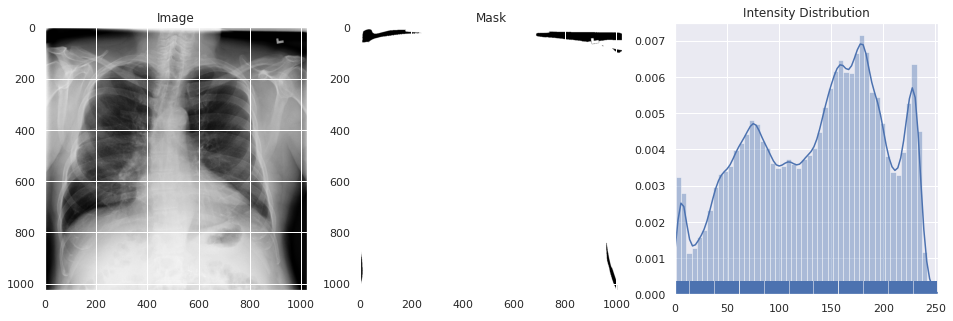

In [79]:
for img in df_sample_pneu.head(10).img_data.values:
    show_image_mask(img, bg_th)

### Image intensity distribution for pneumonia on normalized image data

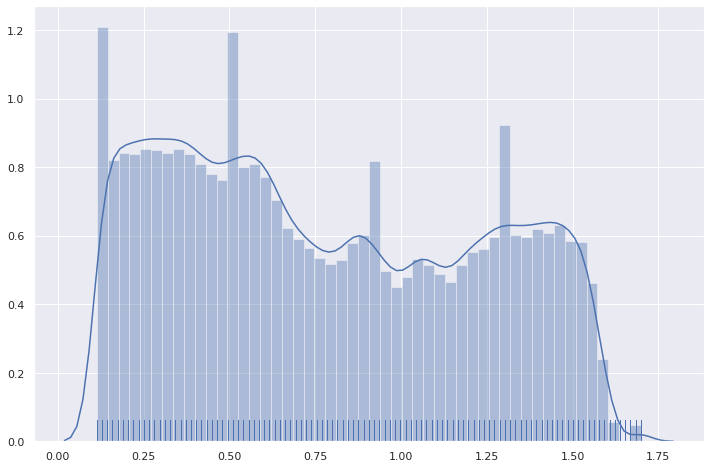

In [80]:
get_dist_plot(get_intensities('Pneumonia', bg_th))

### Compare intensity profiles of different labels for normalized image data

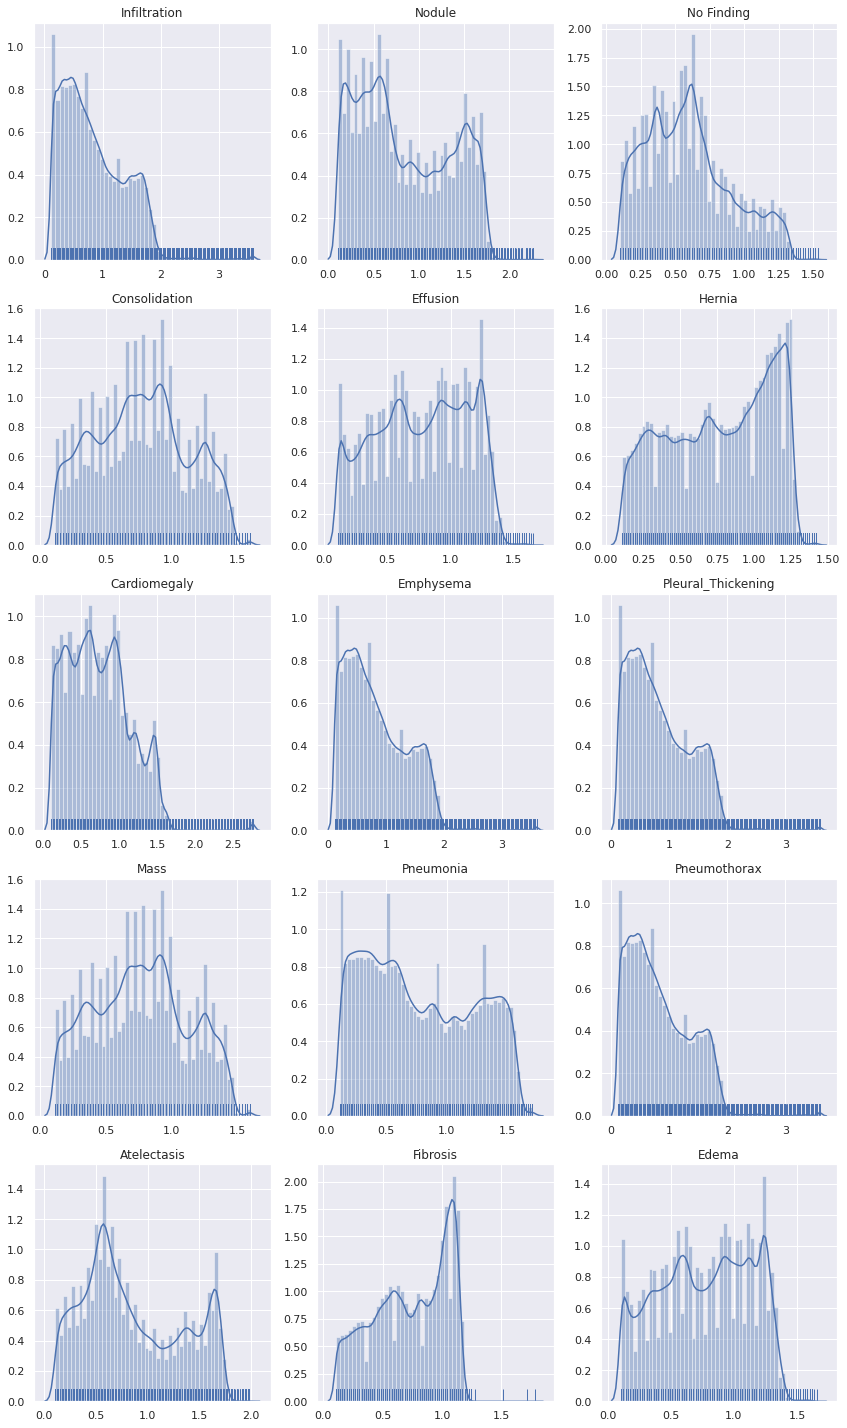

In [81]:
f = plt.figure(figsize=(12,20))
for i,finding in enumerate(labels):
    intensities = get_intensities(finding, bg_th)
    ax = f.add_subplot(5, 3, i+1)
    ax.set_title(finding)
    sns.distplot(intensities, rug=True)
plt.tight_layout()

We can group some of those distributions that look very similar:

1. **Infiltration, Pleural_Thickening, Pneumothorax, Emphysema**
    * A pulmonary infiltrate is a substance denser than air, such as pus, blood, or protein, which lingers within the parenchyma of the lungs. Pulmonary infiltrates are associated with pneumonia, tuberculosis, and nocardiosis. Pulmonary infiltrates can be observed on a chest radiograph. [source](https://en.wikipedia.org/wiki/Pulmonary_infiltrate#:~:text=A%20pulmonary%20infiltrate%20is%20a,observed%20on%20a%20chest%20radiograph.)
    * Pleural thickening refers to a thickening of the lining of the lungs, the pleura, which is a thin layer of membrane that covers the inside of the rib-cage as well as the outside of the lungs. [source](https://www.nationalasbestos.co.uk/news/what-are-the-symptoms-of-pleural-thickening/#:~:text=Pleural%20thickening%20refers%20to%20a,extent%20that%20it%20causes%20breathlessness.)
    * A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall. [source](https://en.wikipedia.org/wiki/Pneumothorax)
    * Emphysema is a lung condition that causes shortness of breath. In people with emphysema, the air sacs in the lungs (alveoli) are damaged. [source](https://www.mayoclinic.org/diseases-conditions/emphysema/symptoms-causes/syc-20355555)


2. **Effusion, Edema**
    * Edema is the generalized swelling of tissues caused by inflammation, allergy, heart failure, and other conditions.
    * Effusion, by contrast, specifically describes the swelling of a joint. [source](https://www.verywellhealth.com/what-is-joint-effusion-189282#:~:text=An%20effusion%20should%20not%20be,the%20swelling%20of%20a%20joint.)


3. **Consolidation, Mass**
    * Lung cancer appear as a mass or as an area of consolidation on a chest X-ray. [source](https://www.radiologymasterclass.co.uk/gallery/chest/lung_cancer/mass_consolidation)

Note: pixel intensity value spikes at `intensity = 0` are usually due to background pixels.

---

# Summary

To summarize,

**Patient gender**
* We have a slight imbalance between Males (56.49%) and Females (43.51%) in the dataset.

**Patient age**
* There are outliers of patients older than 100 years old. These patient ages above 100 don't make much sense: 148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, 414. When modeling, we should handle these outliers.

**Follow-up #**
* The distribution of follow-up # seems to be exponential.

**X-ray views taken**
* There are more PA (60.03%) than AP (39.97%).

**Number of records per patient**
* On average, there are 3.64 records per patient.
* The number of records per patient distribution seems to be exponential, with more than half (56.82%) of the patients having only one record/image associated with them.
* The dataset contains multiple images for some patient. The data splitting should be done on patient level to avoid data leakage.

**Finding labels**
* There are 15 unique finding labels: 
    * 'Atelectasis',
    * 'Cardiomegaly',
    * 'Consolidation',
    * 'Edema',
    * 'Effusion',
    * 'Emphysema',
    * 'Fibrosis',
    * 'Hernia',
    * 'Infiltration',
    * 'Mass',
    * 'No Finding',
    * 'Nodule',
    * 'Pleural_Thickening',
    * 'Pneumonia',
    * 'Pneumothorax'
* More than half the records have no finding (53.84%)

**Pneumonia in patients**
* We see more males (58.56%) within the pneumonia cases than females (41.44%).
* Average records per pneumonia patient is 1.42.

**Number of diseases per patient**
* Most patients have records of only one unique disease (65.65%), some have two (13.45%). Very few patients have three or more unique disease records.

**Distribution of other diseases that are comorbid with Pneumonia**
* Out of all 30805 unique patients, 1008 patients have pneumonia. Out of these pneumonia patients, there are 27 unique patients who have only pneumonia and no other disease.
* The most common diseases that co-occur with pneumonia are: Infiltration, Edema, Effusion, and Atelectasis.

**Image width, image height, and pixel spacing**
* The most common image dimensions are 2500x2048 (33.14%), 2992x2991 (19.59%), and 3056x2544 (13.68%).

**Pixel-level assessment of imaging data**
* As we have only a small handful of cases for pneumonia, we should consider image augmentation to enrich our training set.
* We should also consider removing background (very black) and dimming foreground (very white). For this exercise we used a background threshold, but we should likely raise that as the mask didn't cover the entirety of backgrounds as seen in the outputs.
* Diseases' image intensity distributions that are similar after normalization:

    1. **Infiltration, Pleural_Thickening, Pneumothorax, Emphysema**
        * A pulmonary infiltrate is a substance denser than air, such as pus, blood, or protein, which lingers within the parenchyma of the lungs. Pulmonary infiltrates are associated with pneumonia, tuberculosis, and nocardiosis. Pulmonary infiltrates can be observed on a chest radiograph. ([source](https://en.wikipedia.org/wiki/Pulmonary_infiltrate#:~:text=A%20pulmonary%20infiltrate%20is%20a,observed%20on%20a%20chest%20radiograph.))
        * Pleural thickening refers to a thickening of the lining of the lungs, the pleura, which is a thin layer of membrane that covers the inside of the rib-cage as well as the outside of the lungs. ([source](https://www.nationalasbestos.co.uk/news/what-are-the-symptoms-of-pleural-thickening/#:~:text=Pleural%20thickening%20refers%20to%20a,extent%20that%20it%20causes%20breathlessness.))
        * A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall. ([source](https://en.wikipedia.org/wiki/Pneumothorax))
        * Emphysema is a lung condition that causes shortness of breath. In people with emphysema, the air sacs in the lungs (alveoli) are damaged. [source](https://www.mayoclinic.org/diseases-conditions/emphysema/symptoms-causes/syc-20355555))
    2. **Effusion, Edema**
        * Edema is the generalized swelling of tissues caused by inflammation, allergy, heart failure, and other conditions.
        * Effusion, by contrast, specifically describes the swelling of a joint. ([source](https://www.verywellhealth.com/what-is-joint-effusion-189282#:~:text=An%20effusion%20should%20not%20be,the%20swelling%20of%20a%20joint.))
    3. **Consolidation, Mass**
        * Lung cancer appear as a mass or as an area of consolidation on a chest X-ray. ([source](https://www.radiologymasterclass.co.uk/gallery/chest/lung_cancer/mass_consolidation))